Library

In [ ]:
!pip install openai==0.28
!pip install nltk
!pip install rdflib

In [ ]:
import openai
import os
import re
import numpy as np
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')  # Downloads the WordNet lemmatizer component


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#printing raw output from API and separated one (sepration doesnt work good)
### Always use more tokens for better output, otherwise it might bot generate all the required field outputs ###

api_key = 'YOUR_CHATGPT_KEY'

openai.api_key = api_key

# Input text for processing
input_text = "Iam going to bank. Swimming in summer is good"# Setup for the OpenAI Chat API request
messages = [
    {"role": "system", "content": "You are an expert on Knowledge graph and Ontologies formation."},
    {"role": "user", "content": f"Could you please convert the following text: ‘{input_text}’ and identify the entities, one word relationships, and triples among the identified entities and relationships? Please follow this structure only for the output (Entities: [Entity 1, Entity 2,...]), (Realtionships : [Realtionship 1, Realtionship 2,...]), (Triples : [Triple 1, Triple 2,...)"}
]

response = openai.ChatCompletion.create(
    model="gpt-4",
    messages=messages,
    max_tokens=3000  # Increase max_tokens if necessary to get complete outputs
)

# Extracting and displaying the content from the response
output = response.choices[0].message["content"]
#print("Raw output from ChatGPT:\n", output)
#print(type(output))

In [ ]:
print(output)

Entities: ['I', 'bank', 'swimming', 'summer']

Relationships: ['going to', 'in']

Triples: [('I', 'going to', 'bank'), ('swimming', 'in', 'summer')]



In [ ]:
#Passed TEST:fetching relationship and triples sepration from the raw output
import re

def partition_string(output, pattern):
    match = re.search(pattern, output)
    if match:
        start_index = match.start()
        end_index = output.find(']', start_index)
        if end_index != -1:
            entities_part = output[start_index:end_index + 1].strip()
            rest_part = output[:start_index].strip() + " " + output[end_index + 1:].strip()
            return entities_part, rest_part
    return None, output


entities_part, rest_part = partition_string(output, r'[eE]nt\w*\s*:\s*\[')
relations_part, final_rest = partition_string(rest_part, r'[rR]elat\w*\s*:\s*\[')



triple_part, final_rest = partition_string(final_rest, r'[tT]rip\w*\s*:\s*\[')

#print(entities_part)
#print(relations_part)

#print(triple_part)

entities_list = [entity.strip() for entity in entities_part.replace("Entities: [", "").rstrip("]").split(",")]
relations_list = [relation.strip() for relation in relations_part.replace("Relationships: [", "").rstrip("]").split(",")]

In [ ]:
print(entities_list)
print(relations_list)

["'I'", "'bank'", "'swimming'", "'summer'"]
["'going to'", "'in'"]


From here word comparison thing starts

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer

# Ensure necessary NLTK resources are downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')  # Open Multilingual Wordnet

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_words(words):
    # Converts words to lowercase and then lemmatizes them
    return set(lemmatizer.lemmatize(word.lower()) for word in words.split())

# # Your lists
# entities_list = ["Knowledge graph", "Water quality", "Health risks"]
# relationships_list = ["focus on", "relate to", "pose by"]

# # Input text
# input_text = "The water qualities at the beach affect the health risk associated with swimming."

# Convert input text to a set of lemmatized words (all lowercase for case-insensitive comparison)
input_text_words = lemmatize_words(input_text)

# Function to check if list elements are subsets of input text words and collect non-matching elements
def collect_non_matches(items_list):
    not_found = []
    for element in items_list:
        element_words = lemmatize_words(element)  # Set of lemmatized words from the list element
        if not element_words.issubset(input_text_words):  # Check subset relation
            not_found.append(element)
    return not_found

# Collect non-matching elements from both lists
not_found_entities = collect_non_matches(entities_list)
not_found_relationships = collect_non_matches(relations_list)

# Combine the non-matching elements into a single list
combined_not_found_list = not_found_entities + not_found_relationships

# Print the combined list of not found words
print("Combined list of not found words/phrases:", combined_not_found_list)


Combined list of not found words/phrases: ["'I'", "'bank'", "'swimming'", "'summer'", "'going to'", "'in'"]


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
print(input_text_words)

{'good', 'is', 'bank.', 'iam', 'swimming', 'summer', 'going', 'in', 'to'}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Average cosine similarity scores across all models for the target word "'I'":
Word: good, Average Similarity: 0.6953
Word: is, Average Similarity: 0.7156
Word: bank., Average Similarity: 0.6934
Word: iam, Average Similarity: 0.7093
Word: swimming, Average Similarity: 0.6196
Word: summer, Average Similarity: 0.6796
Word: going, Average Similarity: 0.7180
Word: in, Average Similarity: 0.7234
Word: to, Average Similarity: 0.6942


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Average cosine similarity scores across all models for the target word "'bank'":
Word: good, Average Similarity: 0.6930
Word: is, Average Similarity: 0.7163
Word: bank., Average Similarity: 0.8126
Word: iam, Average Similarity: 0.6756
Word: swimming, Average Similarity: 0.6412
Word: summer, Average Similarity: 0.6843
Word: going, Average Similarity: 0.7109
Word: in, Average Similarity: 0.7021
Word: to, Average Similarity: 0.6885


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Average cosine similarity scores across all models for the target word "'swimming'":
Word: good, Average Similarity: 0.6998
Word: is, Average Similarity: 0.6893
Word: bank., Average Similarity: 0.6783
Word: iam, Average Similarity: 0.6829
Word: swimming, Average Similarity: 0.7788
Word: summer, Average Similarity: 0.7295
Word: going, Average Similarity: 0.7191
Word: in, Average Similarity: 0.6988
Word: to, Average Similarity: 0.6595


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Average cosine similarity scores across all models for the target word "'summer'":
Word: good, Average Similarity: 0.6950
Word: is, Average Similarity: 0.7014
Word: bank., Average Similarity: 0.6680
Word: iam, Average Similarity: 0.6874
Word: swimming, Average Similarity: 0.6483
Word: summer, Average Similarity: 0.8120
Word: going, Average Similarity: 0.7142
Word: in, Average Similarity: 0.6979
Word: to, Average Similarity: 0.6709


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Average cosine similarity scores across all models for the target word "'going to'":
Word: good, Average Similarity: 0.7087
Word: is, Average Similarity: 0.7050
Word: bank., Average Similarity: 0.6881
Word: iam, Average Similarity: 0.7020
Word: swimming, Average Similarity: 0.6470
Word: summer, Average Similarity: 0.6916
Word: going, Average Similarity: 0.7654
Word: in, Average Similarity: 0.7085
Word: to, Average Similarity: 0.7028


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Average cosine similarity scores across all models for the target word "'in'":
Word: good, Average Similarity: 0.7237
Word: is, Average Similarity: 0.7548
Word: bank., Average Similarity: 0.6876
Word: iam, Average Similarity: 0.7088
Word: swimming, Average Similarity: 0.6355
Word: summer, Average Similarity: 0.6939
Word: going, Average Similarity: 0.7349
Word: in, Average Similarity: 0.7735
Word: to, Average Similarity: 0.7221


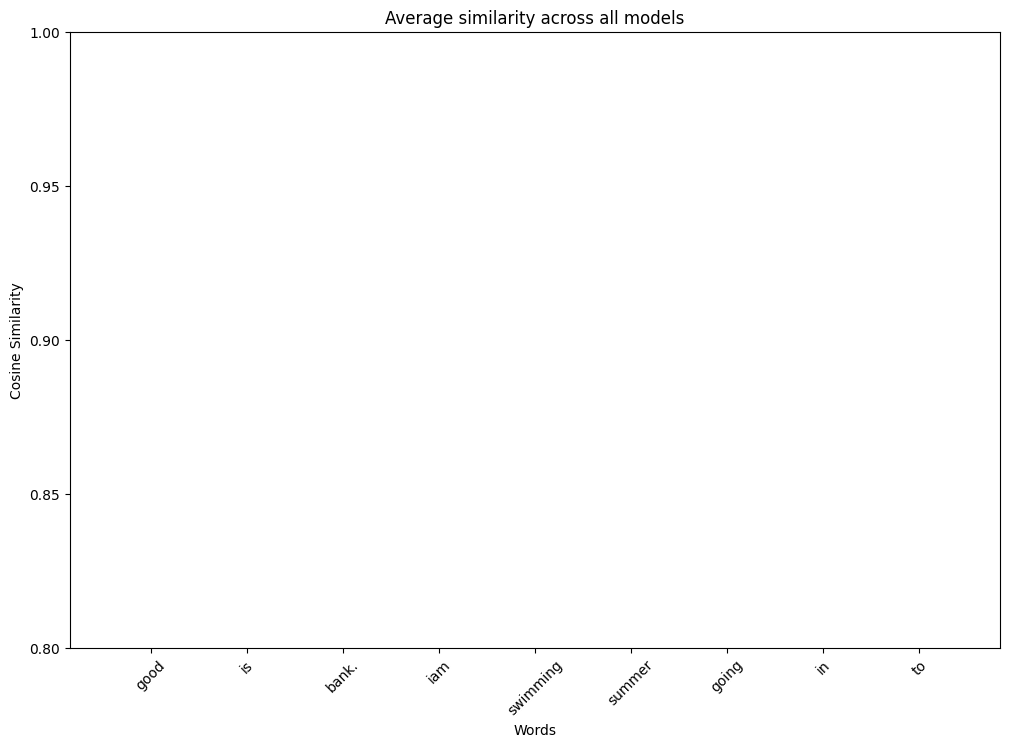

Target words with average similarity below 0.80: ["'I'", "'swimming'", "'going to'", "'in'"]


In [ ]:


openai.api_key

def get_openai_embedding(text):
    response = openai.Embedding.create(input=text, model="text-embedding-ada-002")
    return np.array(response['data'][0]['embedding'])

def get_bert_embedding(text):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.numpy().flatten()

# def get_roberta_embedding(text):
#     tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
#     model = RobertaModel.from_pretrained('roberta-base')
#     inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     embeddings = outputs.last_hidden_state.mean(dim=1)
#     return embeddings.numpy().flatten()


target_words = combined_not_found_list
comparison_words =  input_text_words


def calculate_similarities(get_embedding_func, target_word):
    word_vector = get_embedding_func(target_word).reshape(1, -1)
    comparison_vectors = [get_embedding_func(w).reshape(1, -1) for w in comparison_words]
    similarities = [cosine_similarity(word_vector, vec)[0][0] for vec in comparison_vectors]
    return similarities

def calculate_average_similarity(similarities_list):
    return np.mean(similarities_list, axis=0)

low_similarity_words = []


for target_word in target_words:
    openai_similarities = calculate_similarities(get_openai_embedding, target_word)
    bert_similarities = calculate_similarities(get_bert_embedding, target_word)
    # roberta_similarities = calculate_similarities(get_roberta_embedding, target_word)


    min_length = min(len(openai_similarities), len(bert_similarities)) #,len(roberta_similarities))
    openai_similarities = openai_similarities[:min_length]
    bert_similarities = bert_similarities[:min_length]
    # roberta_similarities = roberta_similarities[:min_length]

    all_similarities = np.array([openai_similarities, bert_similarities])#, roberta_similarities])
    average_similarities = calculate_average_similarity(all_similarities)

    print(f'\nAverage cosine similarity scores across all models for the target word "{target_word}":')
    highest_similarity = 0.0

    comparison_words_list = list(comparison_words)

    for word, avg_sim in zip(comparison_words_list[:min_length], average_similarities):
        print(f'Word: {word}, Average Similarity: {avg_sim:.4f}')
        highest_similarity = max(highest_similarity, avg_sim)

    if highest_similarity < 0.80:
        low_similarity_words.append(target_word)

def plot_average_similarity(average_similarities):
    plt.figure(figsize=(12, 8))

    plt.bar(comparison_words_list[:min_length], average_similarities, color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Cosine Similarity')
    plt.title('Average similarity across all models')
    plt.xticks(rotation=45)
    plt.ylim(0.8, 1.0)
    plt.yticks(np.arange(0.8, 1.05, 0.05))
    plt.show()

plot_average_similarity(average_similarities)

if len(low_similarity_words) < 1:
    print("No Hallucination introduced")
else:
    print(f'Target words with average similarity below 0.80: {low_similarity_words}')





In [ ]:
#updates the entitites and relations based on the word embeddings
list1 = entities_list
list2 = relations_list
delete_list = low_similarity_words

def remove_elements_case_insensitive(original_list, elements_to_delete):
    delete_set = set(element.lower() for element in elements_to_delete)
    return [item for item in original_list if item.lower() not in delete_set]


entities_list = remove_elements_case_insensitive(list1, delete_list)
relations_list = remove_elements_case_insensitive(list2, delete_list)


# print("Updated List 1:", entities_list)
# print("Updated List 2:", relations_list)


In [ ]:
#!pip install openai==0.28
import openai


openai.api_key

# Input text for processing
input_text = "A knowledge graph focusing on water quality in relation to health risks posed by water activities (such as diving or swimming) is not currently available. To address this limitation, we first use existing resources to construct a knowledge graph relevant to water quality and health risks using KNowledge Acquisition and Representation Methodology (KNARM). Subsequently, we explore knowledge graph completion approaches for maintaining and updating the graph. Specifically, we manually identify a set of domain specific UMLS concepts and use them to extract a graph of approximately 75,000 semantic triples from the Semantic MEDLINE database (which contains head-relation-tail triples extracted from PubMed). Using the resulting knowledge graph, we experiment with the KG-BERT approach for graph completion by employing pre-trained BERT/RoBERTa models and also models fine-tuned on a collection of water quality and health risks abstracts retrieved from the Web of Science. Experimental results show that KG-BERT with BERT/RoBERTa models fine-tuned on a domain-specific corpus improves the performance of KG-BERT with pre-trained models. Furthermore, KG-BERT gives better results than several translational distance or semantic matching baseline models"

# Setup for the OpenAI Chat API request
messages = [
    {"role": "system", "content": "You are an expert on Knowledge graph and Ontologies formation."},
    {"role": "user", "content": f"Could you please consatruct triple from the following entities: ‘{entities_list}’ and relations ‘{relations_list}. Please follow this structure only for the output (Entities: [Entity 1, Entity 2,...]), (Realtionships : [Realtionship 1, Realtionship 2,...]), (Triples : [Triple 1, Triple 2,...), once constructed use {input_text} to validate the triples formed and remove any inconsistancy. At the end please validate if triple have subject, predicate, object from the {entities_list}, and {relations_list}, output should only give triples no other senetence"}
]

response = openai.ChatCompletion.create(
    model="gpt-4",
    messages=messages,
    max_tokens=3000  # Increase max_tokens if necessary to get complete outputs
)

# Extracting and displaying the content from the response
output1 = response.choices[0].message["content"]

In [ ]:
print(output1)

As per your instructions, I am supposed to create triples using the entities 'bank' and 'summer'. However, no relation has been provided which makes the creation of triples impossible. A triple follows the structure of (Entity, Relation, Entity). Without knowing the relationship, we can't establish a meaningful link or a triple between 'bank' and 'summer'. Please provide a relation set, and I'd be glad to assist you further.


In [ ]:
entities_part, rest_part = partition_string(output1, r'[eE]nt\w*\s*:\s*\[')

relations_part, triple_part = partition_string(rest_part, r'[rR]elat\w*\s*:\s*\[')

if triple_part==None:
  ent_rel, triple_part = partition_string(final_rest, r'[tT]rip\w*\s*:\s*\[')




In [ ]:
#converting into string to list
import re

# Original string with tuples
triple_part
# Pattern to match tuples within parentheses
pattern = r'\(([^)]+)\)'

# Find all matches
matches = re.findall(pattern, triple_part)

# Convert matches to a list of tuples
triples_list = [tuple(map(str.strip, match.split(','))) for match in matches]

# Output the result to verify
print(triples_list)
print(type(triples_list))
print(triples_list[0])


[('Entity', 'Relation', 'Entity')]
<class 'list'>
('Entity', 'Relation', 'Entity')


In [ ]:
# Filter out empty tuples and convert valid triples into lists
triples_list = [tuple_item for tuple_item in triples_list if tuple_item != ('',)]

# Convert each tuple in the list to a separate list
list_of_lists = [list(t) for t in triples_list]

# Output each list
for i, sublist in enumerate(list_of_lists, 1):
    print(f"List{i}: {sublist}")

# Access a specific element (example: first element of the first list)
print(list_of_lists[0][0])

List1: ['Entity', 'Relation', 'Entity']
Entity


In [ ]:
import re
import pprint  # Import the pprint module


#Define conjunctions to split on
conjunctions = ['For', 'And', 'Nor', 'But', 'Or', 'Yet', 'So']

# Combine conjunctions into a regex pattern
conjunction_pattern = re.compile(r'\b(?:' + '|'.join(conjunctions) + r')\b', re.IGNORECASE)

# Function to split the text on conjunctions and compare with respective lists
def validate_triple(triple, entities_list, relations_list):
    entity1, relation, entity2 = [item.strip("'").strip() for item in triple]  # Clean quotes and extra spaces

    # Function to split and check each part (entity or relation)
    def split_and_check(text, check_list):
        substrings = re.split(conjunction_pattern, text)
        substrings = [s.strip() for s in substrings if s.strip()]  # Remove empty and whitespace substrings
        not_found = [s for s in substrings if s not in check_list]  # Find substrings not in the list
        return not_found  # Return substrings that were not found

    # Check if entity1 and entity2 are valid based on the entities_list
    entity1_not_found = split_and_check(entity1, entities_list)
    entity2_not_found = split_and_check(entity2, entities_list)

    # Check if the relation is valid based on the relations_list
    relation_not_found = split_and_check(relation, relations_list)

    # Return detailed information about mismatches
    return {
        'entity1': entity1,
        'entity1_not_found': entity1_not_found,
        'relation': relation,
        'relation_not_found': relation_not_found,
        'entity2': entity2,
        'entity2_not_found': entity2_not_found,
        'is_valid': not (entity1_not_found or relation_not_found or entity2_not_found)  # Valid if no not_found items
    }




# Example usage:
entities_list
relations_list

# Sample list of triples
triples = list_of_lists

# Validate triples
validation_results = []
for triple in triples:
    validation_results.append(validate_triple(triple, entities_list, relations_list))

pp = pprint.PrettyPrinter(width=100, compact=False)
pp.pprint(triples)
print("\n" + "-" * 50 + "\n")
pp.pprint(entities_list)
print("\n" + "-" * 50 + "\n")
pp.pprint(relations_list)
print("\n" + "-" * 50 + "\n")
# Output the detailed validation results
for result in validation_results:
    print(f"Triple: {result['entity1']} | {result['relation']} | {result['entity2']}")
    if result['is_valid']:
        print("Status: VALID")
    else:
        print("Status: INVALID")
        if result['entity1_not_found']:
            print(f"Entity 1 Substrings Not Found: {result['entity1_not_found']}")
        if result['relation_not_found']:
            print(f"Relation Substrings Not Found: {result['relation_not_found']}")
        if result['entity2_not_found']:
            print(f"Entity 2 Substrings Not Found: {result['entity2_not_found']}")
    print("\n" + "-" * 50 + "\n")
    print()  # Blank line for readability

#Validate triples and pop invalid ones
def filter_invalid_triples(triples, entities_list, relations_list):
    i = 0
    while i < len(triples):
        triple = triples[i]
        validation_result = validate_triple(triple, entities_list, relations_list)

        # Print triple and validation status
        print(f"Triple: {validation_result['entity1']} | {validation_result['relation']} | {validation_result['entity2']}")
        if validation_result['is_valid']:
            print("Status: VALID")
            i += 1  # Move to the next triple if it's valid
        else:
            print("Status: INVALID")
            if validation_result['entity1_not_found']:
                print(f"Entity 1 Substrings Not Found: {validation_result['entity1_not_found']}")
            if validation_result['relation_not_found']:
                print(f"Relation Substrings Not Found: {validation_result['relation_not_found']}")
            if validation_result['entity2_not_found']:
                print(f"Entity 2 Substrings Not Found: {validation_result['entity2_not_found']}")
            # Remove invalid triple
            triples.pop(i)
        print("-" * 50)  # Separator for readability

# Run the function to filter invalid triples
filter_invalid_triples(triples, entities_list, relations_list)

# Output the remaining valid triples
print("\nRemaining valid triples:")
for triple in triples:
    print(triple)

[['Entity', 'Relation', 'Entity']]

--------------------------------------------------

["'bank'", "'summer'"]

--------------------------------------------------

[]

--------------------------------------------------

Triple: Entity | Relation | Entity
Status: INVALID
Entity 1 Substrings Not Found: ['Entity']
Relation Substrings Not Found: ['Relation']
Entity 2 Substrings Not Found: ['Entity']

--------------------------------------------------


Triple: Entity | Relation | Entity
Status: INVALID
Entity 1 Substrings Not Found: ['Entity']
Relation Substrings Not Found: ['Relation']
Entity 2 Substrings Not Found: ['Entity']
--------------------------------------------------

Remaining valid triples:


**Run untill here continuosly **

In [ ]:
from rdflib import Graph, Literal, RDF, URIRef
from rdflib.namespace import RDFS, OWL, XSD
import urllib.parse

# Sample triples input
triples

# Function to sanitize URIs
def sanitize_uri(text):
    return urllib.parse.quote(text.replace(" ", "_").replace("'", ""))

# Function to create the ontology from triples
def create_ontology(triples):
    # Create a new RDF graph
    g = Graph()

    # Define namespaces
    base = "http://example.org/"
    g.bind("rdfs", RDFS)
    g.bind("owl", OWL)
    g.bind("xsd", XSD)

    # Loop through each triple and add it to the graph
    for s, p, o in triples:
        # Sanitize and create URIs for subject, predicate, and object
        subject = URIRef(f"{base}entity/{sanitize_uri(s)}")
        predicate = URIRef(f"{base}relation/{sanitize_uri(p)}")
        obj = URIRef(f"{base}entity/{sanitize_uri(o)}")

        # Add the triple to the graph
        g.add((subject, predicate, obj))

        # Add labels for subject, predicate, and object for readability
        g.add((subject, RDFS.label, Literal(s, datatype=XSD.string)))
        g.add((predicate, RDFS.label, Literal(p, datatype=XSD.string)))
        g.add((obj, RDFS.label, Literal(o, datatype=XSD.string)))

        # Add RDF/OWL type information
        g.add((subject, RDF.type, OWL.Class))  # Assuming subjects are classes/entities
        g.add((obj, RDF.type, OWL.Class))      # Assuming objects are also classes/entities
        g.add((predicate, RDF.type, RDF.Property))  # Predicates as object properties

    # Serialize the graph to an OWL file in RDF/XML format
    try:
        g.serialize(destination="ontology.owl", format="xml")
        print("Ontology saved as 'ontology.owl'.")
    except Exception as e:
        print(f"Error saving ontology: {e}")

# Create the ontology from the triples
create_ontology(triples)


Ontology saved as 'ontology.owl'.


#Triple validation completed

In [ ]:
from rdflib import Graph, Literal, RDF, URIRef
from rdflib.namespace import RDFS, OWL, XSD
import urllib.parse
import openai

# Function to sanitize URIs
def sanitize_uri(text):
    return urllib.parse.quote(text.replace(" ", "_").replace("'", ""))

# Function to get a short definition of an entity using OpenAI's API
def get_entity_definition(entity_name):
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",  # You can use the latest model available to you
            messages=[
                {"role": "system", "content": "You are an expert in summarizing and defining concepts."},
                {"role": "user", "content": f"Provide a brief definition of the following entity: {entity_name}"}
            ],
            max_tokens=50
        )
        definition = response.choices[0].message['content'].strip()
        return definition
    except Exception as e:
        print(f"Error getting definition for {entity_name}: {e}")
        return None

# Function to create the ontology from triples
def create_ontology(triples):
    # Create a new RDF graph
    g = Graph()

    # Define namespaces
    base = "http://example.org/"
    g.bind("rdfs", RDFS)
    g.bind("owl", OWL)
    g.bind("xsd", XSD)

    # Loop through each triple and add it to the graph
    for s, p, o in triples:
        # Sanitize and create URIs for subject, predicate, and object
        subject = URIRef(f"{base}entity/{sanitize_uri(s)}")
        predicate = URIRef(f"{base}relation/{sanitize_uri(p)}")
        obj = URIRef(f"{base}entity/{sanitize_uri(o)}")

        # Add the triple to the graph
        g.add((subject, predicate, obj))

        # Add labels for subject, predicate, and object for readability
        g.add((subject, RDFS.label, Literal(s, datatype=XSD.string)))
        g.add((predicate, RDFS.label, Literal(p, datatype=XSD.string)))
        g.add((obj, RDFS.label, Literal(o, datatype=XSD.string)))

        # Add RDF/OWL type information
        g.add((subject, RDF.type, OWL.Class))  # Assuming subjects are classes/entities
        g.add((obj, RDF.type, OWL.Class))      # Assuming objects are also classes/entities
        g.add((predicate, RDF.type, RDF.Property))  # Predicates as object properties

        # Fetch and add definitions for the subject and object entities
        subject_definition = get_entity_definition(s)
        if subject_definition:
            g.add((subject, RDFS.comment, Literal(subject_definition, datatype=XSD.string)))

        object_definition = get_entity_definition(o)
        if object_definition:
            g.add((obj, RDFS.comment, Literal(object_definition, datatype=XSD.string)))

    # Serialize the graph to an OWL file in RDF/XML format
    try:
        g.serialize(destination="ontology.owl", format="xml")
        print("Ontology saved as 'ontology.owl'.")
    except Exception as e:
        print(f"Error saving ontology: {e}")

# Example triples input
triples
# OpenAI API Key setup
openai.api_key

# Create the ontology from the triples
create_ontology(triples)


Ontology saved as 'ontology.owl'.
